In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import matplotlib.pyplot as plt
from gstools import SRF, Gaussian
from gstools.random import MasterRNG

#############################################
# 1. Second Order Finite Element Solver
#############################################

def solve_diffusion_reaction_fem(u, D=0.01, k=0.01, Ne=50, Nt=100):
    """
    Solves the PDE
       s_t = D s_{xx} + k s^2 + u(x)
    on x in [0,1] and t in [0,1] with zero initial and Dirichlet boundary conditions,
    using a second order (quadratic) finite element method in space and Crank-Nicolson in time.
    
    Parameters:
      u  : 1D array of length Nx (with Nx = 2*Ne+1) giving u(x) at the FEM nodes.
      D  : Diffusion coefficient.
      k  : Reaction rate.
      Ne : Number of elements (each quadratic element has 3 nodes, with global nodes Nx=2*Ne+1).
      Nt : Number of time steps.
      
    Returns:
      s : Array of shape (Nt, Nx) with the solution s(x,t).
      x : Global spatial coordinates (length Nx).
      t : Time grid (length Nt).
    """
    Nx = 2 * Ne + 1
    x = np.linspace(0, 1, Nx)
    t = np.linspace(0, 1, Nt)
    dt = t[1] - t[0]
    h = 1 / Ne  # element length

    # Assemble global mass matrix M and stiffness matrix K (size Nx x Nx)
    M = np.zeros((Nx, Nx))
    K = np.zeros((Nx, Nx))
    
    # 3-point Gauss–Legendre quadrature on the reference element [-1, 1]
    gp = np.array([-np.sqrt(3/5), 0.0, np.sqrt(3/5)])
    gw = np.array([5/9, 8/9, 5/9])
    
    # Quadratic shape functions on the reference element and their derivatives
    def N1(xi): return 0.5 * xi * (xi - 1)
    def N2(xi): return 1 - xi**2
    def N3(xi): return 0.5 * xi * (xi + 1)
    def dN1(xi): return xi - 0.5
    def dN2(xi): return -2 * xi
    def dN3(xi): return xi + 0.5
    shape_funcs = [N1, N2, N3]
    dshape_funcs = [dN1, dN2, dN3]
    
    # Loop over elements; local node indices for element e are [2e, 2e+1, 2e+2]
    for e in range(Ne):
        nodes = [2*e, 2*e+1, 2*e+2]
        M_e = np.zeros((3, 3))
        K_e = np.zeros((3, 3))
        J = h / 2  # Jacobian of the mapping
        for i in range(3):
            for j in range(3):
                integral_M = 0.0
                integral_K = 0.0
                for q in range(len(gp)):
                    xi_val = gp[q]
                    w = gw[q]
                    Ni = shape_funcs[i](xi_val)
                    Nj = shape_funcs[j](xi_val)
                    dNi_dxi = dshape_funcs[i](xi_val)
                    dNj_dxi = dshape_funcs[j](xi_val)
                    dNi_dx = dNi_dxi / J
                    dNj_dx = dNj_dxi / J
                    integral_M += w * Ni * Nj * J
                    integral_K += w * dNi_dx * dNj_dx * J
                M_e[i, j] = integral_M
                K_e[i, j] = integral_K
        for i_local, i_global in enumerate(nodes):
            for j_local, j_global in enumerate(nodes):
                M[i_global, j_global] += M_e[i_local, j_local]
                K[i_global, j_global] += K_e[i_local, j_local]
    
    # Apply homogeneous Dirichlet BCs: remove first and last DOFs.
    interior = np.arange(1, Nx - 1)
    M_int = M[np.ix_(interior, interior)]
    K_int = K[np.ix_(interior, interior)]
    u_int = u[interior]
    
    s = np.zeros((Nt, Nx))
    A = M_int + (dt * D / 2) * K_int
    B = M_int - (dt * D / 2) * K_int
    
    for n in range(Nt - 1):
        s_int_n = s[n, interior]
        reaction = k * (s_int_n ** 2)
        rhs = B.dot(s_int_n) + dt * M_int.dot(reaction + u_int)
        s_next = np.linalg.solve(A, rhs)
        s[n + 1, interior] = s_next
    return s, x, t

#############################################
# 2. Dataset Generation Using FEM Solver
#############################################

def generate_u_FEM(Nx):
    """
    Generates a random source function u(x) on [0,1] at the FEM nodes (length Nx)
    using gstools.
    """
    seed = MasterRNG(np.random.randint(1, 10000))
    x = np.linspace(0, 1, Nx)
    model_g = Gaussian(dim=1, var=1, len_scale=0.2)
    srf = SRF(model_g, seed=seed())
    u = srf.structured([x])
    return u

def diff_reaction_dataset_FEM(P, num_u, Ne=50, Nt=100):
    """
    For each forcing function u(x) (of length Nx, where Nx = 2*Ne+1) we solve the PDE
    using the FEM solver and then randomly sample P points from the full Nt x Nx solution.
    
    Each sample is a triple:
      - Branch input: the entire u(x) (vector of length Nx)
      - Trunk input: the coordinate (x,t) (2D)
      - Output: the solution s(x,t) at that coordinate.
      
    The total dataset size is num_u * P.
    """
    Nx = 2 * Ne + 1
    U_all = []         # store u(x)
    trunk_inputs = []  # store (x,t)
    outputs = []       # store s(x,t)
    
    for i in range(num_u):
        u = generate_u_FEM(Nx)  # shape (Nx,)
        s, x_grid, t_grid = solve_diffusion_reaction_fem(u, D=0.01, k=0.01, Ne=Ne, Nt=Nt)
        T, X = np.meshgrid(t_grid, x_grid, indexing='ij')  # shapes (Nt, Nx)
        s_flat = s.flatten()       # shape (Nt*Nx,)
        T_flat = T.flatten()       # shape (Nt*Nx,)
        X_flat = X.flatten()       # shape (Nt*Nx,)
        total_points = Nt * Nx
        indices = np.random.choice(total_points, size=P, replace=False)
        for idx in indices:
            U_all.append(u)             # same u for all points from this PDE solution
            trunk_inputs.append([X_flat[idx], T_flat[idx]])
            outputs.append(s_flat[idx])
    U_all = np.array(U_all)               # (num_u * P, Nx)
    trunk_inputs = np.array(trunk_inputs)   # (num_u * P, 2)
    outputs = np.array(outputs)             # (num_u * P,)
    return U_all, trunk_inputs, outputs

# Specify numbers for training and testing.
num_u_train = 80
num_u_test  = 20
P = 50

# Generate datasets.
U_train_all, trunk_train, outputs_train = diff_reaction_dataset_FEM(P, num_u_train, Ne=50, Nt=100)
U_test_all,  trunk_test,  outputs_test  = diff_reaction_dataset_FEM(P, num_u_test, Ne=50, Nt=100)

# Convert to PyTorch tensors.
U_train_tensor = torch.tensor(U_train_all, dtype=torch.float32)
trunk_train_tensor = torch.tensor(trunk_train, dtype=torch.float32)
outputs_train_tensor = torch.tensor(outputs_train, dtype=torch.float32).unsqueeze(1)

U_test_tensor = torch.tensor(U_test_all, dtype=torch.float32)
trunk_test_tensor = torch.tensor(trunk_test, dtype=torch.float32)
outputs_test_tensor = torch.tensor(outputs_test, dtype=torch.float32).unsqueeze(1)

train_dataset = torch.utils.data.TensorDataset(U_train_tensor, trunk_train_tensor, outputs_train_tensor)
test_dataset  = torch.utils.data.TensorDataset(U_test_tensor, trunk_test_tensor, outputs_test_tensor)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#############################################
# 3. DeepONet Model Definition
#############################################

class DeepONet(nn.Module):
    def __init__(self, branch_in, trunk_in, neurons=50, output_neurons=50):
        """
        branch_in: Dimension of branch input (u(x), here = Nx)
        trunk_in : Dimension of trunk input (here, 2 for (x,t))
        """
        super(DeepONet, self).__init__()
        # Branch network (5 layers, 50 neurons per hidden layer)
        self.branch_net = nn.Sequential(
            nn.Linear(branch_in, neurons),
            nn.Tanh(),
            nn.Linear(neurons, neurons),
            nn.Tanh(),
            nn.Linear(neurons, neurons),
            nn.Tanh(),
            nn.Linear(neurons, neurons),
            nn.Tanh(),
            nn.Linear(neurons, output_neurons)
        )
        # Trunk network (5 layers, 50 neurons per hidden layer)
        self.trunk_net = nn.Sequential(
            nn.Linear(trunk_in, neurons),
            nn.Tanh(),
            nn.Linear(neurons, neurons),
            nn.Tanh(),
            nn.Linear(neurons, neurons),
            nn.Tanh(),
            nn.Linear(neurons, neurons),
            nn.Tanh(),
            nn.Linear(neurons, output_neurons)
        )
        self.bias = nn.Parameter(torch.tensor(0.0))
        
    def forward(self, u, xt):
        # u: (batch, branch_in); xt: (batch, 2)
        branch_out = self.branch_net(u)   # (batch, output_neurons)
        trunk_out = self.trunk_net(xt)      # (batch, output_neurons)
        out = torch.sum(branch_out * trunk_out, dim=1, keepdim=True) + self.bias
        return out


In [9]:
# For FEM, branch input dimension equals Nx = 2*Ne+1.
Nx = 2 * 50 + 1
model = DeepONet(branch_in=Nx, trunk_in=2, neurons=50, output_neurons=50)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", device)
model.to(device)

#############################################
# 4. Physics-Informed Loss Function
#############################################

def physics_loss(model, u_batch, Q, D, k, x_fem, device):
    """
    Computes the physics loss by penalizing the PDE residual:
      R = s_t - D s_xx - k s^2,
    where s = Gθ(u)(x,t). The loss is the MSE between R and the forcing u(x)
    evaluated at selected collocation points.
    
    u_batch: (B, Nx) branch inputs.
    Q: number of collocation points per sample.
    x_fem: 1D tensor of FEM node coordinates (length Nx).
    """
    B, Nx = u_batch.shape
    # Choose Q collocation indices among interior nodes (exclude boundaries).
    indices = np.linspace(1, Nx-2, Q, dtype=int)
    # Get x-values at these indices.
    x_coll = x_fem[indices]  # (Q,)
    # Repeat for batch.
    x_coll = x_coll.unsqueeze(0).repeat(B, 1)  # (B, Q)
    # Sample time uniformly in [0,1] for each collocation point.
    t_coll = torch.rand(B, Q, device=device)
    # Build trunk input for physics loss: (B, Q, 2)
    trunk_phys = torch.stack([x_coll, t_coll], dim=2)
    trunk_phys.requires_grad = True
    # Flatten trunk inputs for evaluation: (B*Q, 2)
    trunk_phys_flat = trunk_phys.view(-1, 2)
    
    # **Repeat u_batch for each collocation point.**
    # Expand u_batch from (B, Nx) to (B, Q, Nx) then flatten to (B*Q, Nx)
    u_phys = u_batch.unsqueeze(1).repeat(1, Q, 1).view(-1, Nx)
    
    # Evaluate network output at collocation points.
    s_phys = model(u_phys, trunk_phys_flat)  # (B*Q, 1)
    s_phys = s_phys.view(B * Q)
    
    # Compute gradients wrt trunk inputs.
    grad = torch.autograd.grad(s_phys, trunk_phys_flat,
                               grad_outputs=torch.ones_like(s_phys),
                               create_graph=True)[0]  # (B*Q, 2)
    # Time derivative: derivative w.r.t. t (index 1)
    s_t = grad[:, 1]
    # Spatial derivative: derivative w.r.t. x (index 0)
    s_x = grad[:, 0]
    # Compute second derivative wrt x.
    s_x_sum = s_x.sum()
    grad2 = torch.autograd.grad(s_x_sum, trunk_phys_flat, create_graph=True)[0]  # (B*Q, 2)
    s_xx = grad2[:, 0]
    
    # PDE residual: R = s_t - D s_xx - k s^2.
    R = s_t - D * s_xx - k * (s_phys ** 2)
    
    # The target is u(x) evaluated at the collocation x positions.
    # u_target: from u_batch at the chosen indices, shape (B, Q) flattened to (B*Q,)
    u_target = u_batch[:, indices].view(-1)
    
    loss_phys = torch.mean((R - u_target) ** 2)
    return loss_phys


#############################################
# 5. Training with Physics-Informed Loss
#############################################

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.9**(epoch//1000))
criterion = nn.MSELoss()
epochs = 4000  # adjust as needed
train_losses = []

# Create a tensor for FEM nodes (x coordinates) on device.
x_fem = np.linspace(0, 1, Nx)
x_fem_tensor = torch.tensor(x_fem, dtype=torch.float32, device=device)

# Choose number of physics collocation points per sample.
Q = 50

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for u_batch, xt_batch, s_batch in train_loader:
        u_batch = u_batch.to(device)      # (B, Nx)
        xt_batch = xt_batch.to(device)      # (B, 2)
        s_batch = s_batch.to(device)        # (B, 1)
        
        optimizer.zero_grad()
        # Operator loss: match predicted s with FEM solution s.
        s_pred = model(u_batch, xt_batch)   # (B, 1)
        loss_operator = criterion(s_pred, s_batch)
        # Physics loss: enforce the PDE residual.
        loss_phys = physics_loss(model, u_batch, Q, D=0.01, k=0.01, x_fem=x_fem_tensor, device=device)
        loss_total = loss_operator + loss_phys
        loss_total.backward()
        optimizer.step()
        epoch_loss += loss_total.item()
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    if epoch % 50 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch}, Loss: {epoch_loss:.6f}, LR: {current_lr:.6e}")

Using Device: cuda
Epoch 0, Loss: 0.664492, LR: 1.000000e-03
Epoch 50, Loss: 0.009792, LR: 1.000000e-03
Epoch 100, Loss: 0.003698, LR: 1.000000e-03
Epoch 150, Loss: 0.002925, LR: 1.000000e-03
Epoch 200, Loss: 0.001710, LR: 1.000000e-03
Epoch 250, Loss: 0.001657, LR: 1.000000e-03
Epoch 300, Loss: 0.001687, LR: 1.000000e-03
Epoch 350, Loss: 0.000591, LR: 1.000000e-03
Epoch 400, Loss: 0.001326, LR: 1.000000e-03
Epoch 450, Loss: 0.000553, LR: 1.000000e-03
Epoch 500, Loss: 0.001170, LR: 1.000000e-03
Epoch 550, Loss: 0.000653, LR: 1.000000e-03
Epoch 600, Loss: 0.001088, LR: 1.000000e-03
Epoch 650, Loss: 0.000574, LR: 1.000000e-03
Epoch 700, Loss: 0.000438, LR: 1.000000e-03
Epoch 750, Loss: 0.000448, LR: 1.000000e-03
Epoch 800, Loss: 0.000453, LR: 1.000000e-03
Epoch 850, Loss: 0.000561, LR: 1.000000e-03
Epoch 900, Loss: 0.000756, LR: 1.000000e-03
Epoch 950, Loss: 0.000500, LR: 1.000000e-03
Epoch 1000, Loss: 0.001257, LR: 1.000000e-03
Epoch 1050, Loss: 0.000091, LR: 1.000000e-03
Epoch 1100, Lo

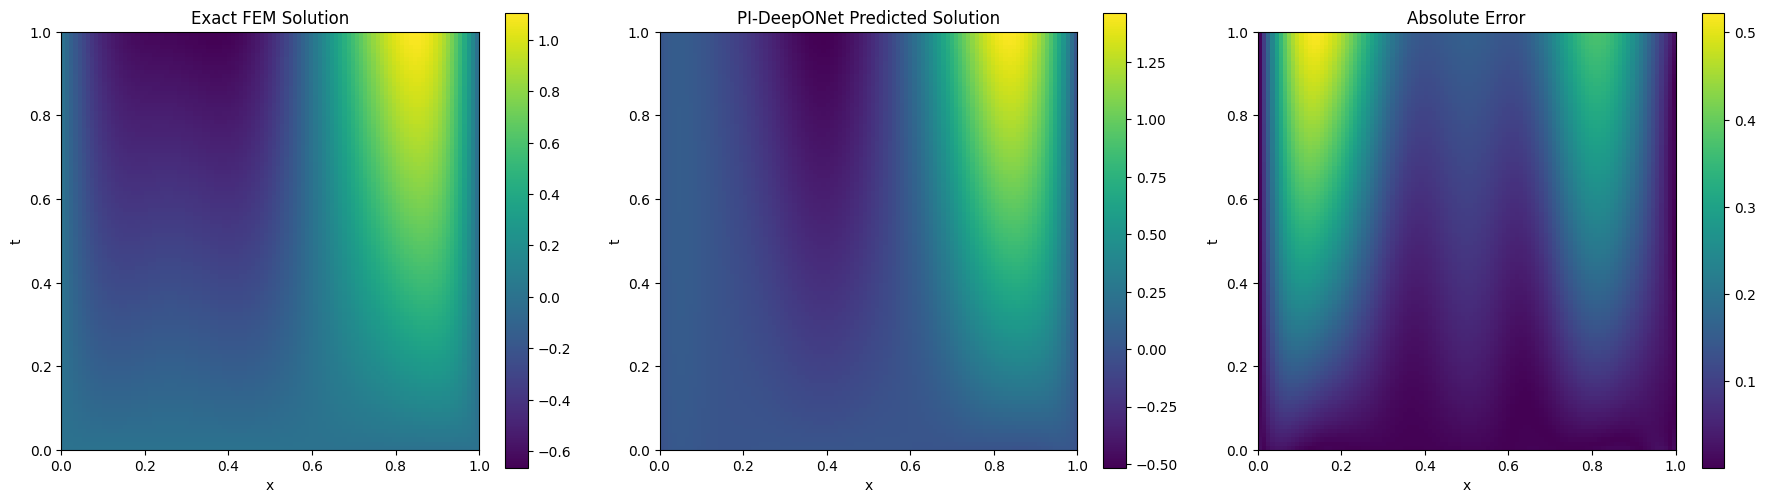

In [10]:

#############################################
# 6. Visualization: Exact vs. PI-DeepONet vs. Absolute Error
#############################################

# For visualization, we pick one test sample.
# For visualization, we pick one test sample.
model.eval()
with torch.no_grad():
    # Choose a test sample (e.g., the first one).
    u_test_sample = U_test_tensor[0].unsqueeze(0).to(device)  # (1, Nx)
    
    # Build a grid over the FEM nodes (x) and time grid (t with Nt=100).
    Nt = 100
    t_vals = np.linspace(0, 1, Nt)
    # x_fem is a numpy array of length Nx, already defined earlier.
    X, T = np.meshgrid(x_fem, t_vals)  # shapes: (Nt, Nx)
    
    # Build trunk inputs: list of (x,t) pairs, shape (Nt*Nx, 2)
    xt_query = np.stack([X.ravel(), T.ravel()], axis=-1)  # (Nt*Nx, 2)
    xt_query_tensor = torch.tensor(xt_query, dtype=torch.float32, device=device)  # (Nt*Nx, 2)
    
    # Repeat the branch input for each query point.
    num_query = Nt * len(x_fem)  # which is Nt * Nx
    u_test_rep = u_test_sample.repeat(num_query, 1)  # (num_query, Nx)
    
    # Evaluate the network on these query points.
    s_pred = model(u_test_rep, xt_query_tensor)  # (num_query, 1)
    s_pred = s_pred.view(Nt, -1).cpu().numpy()     # reshape to (Nt, Nx)
    
# Compute the "exact" FEM solution for this u(x) via our FEM solver.
u_test_np = U_test_tensor[0].cpu().numpy()
s_exact, _, _ = solve_diffusion_reaction_fem(u_test_np, D=0.01, k=0.01, Ne=50, Nt=Nt)

abs_error = np.abs(s_pred - s_exact)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.imshow(s_exact, extent=[0, 1, 0, 1], origin='lower', cmap='viridis')
plt.colorbar()
plt.title("Exact FEM Solution")
plt.xlabel("x")
plt.ylabel("t")

plt.subplot(1, 3, 2)
plt.imshow(s_pred, extent=[0, 1, 0, 1], origin='lower', cmap='viridis')
plt.colorbar()
plt.title("PI-DeepONet Predicted Solution")
plt.xlabel("x")
plt.ylabel("t")

plt.subplot(1, 3, 3)
plt.imshow(abs_error, extent=[0, 1, 0, 1], origin='lower', cmap='viridis')
plt.colorbar()
plt.title("Absolute Error")
plt.xlabel("x")
plt.ylabel("t")

plt.tight_layout()
plt.show()


In [ ]:
# For FEM, branch input dimension equals Nx = 2*Ne+1.
Nx = 2 * 50 + 1
model = DeepONet(branch_in=Nx, trunk_in=2, neurons=50, output_neurons=50)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", device)
model.to(device)

#############################################
# 4. Physics-Informed Loss Function
#############################################

def physics_loss(model, u_batch, Q, D, k, x_fem, device):
    """
    Computes the physics loss by penalizing the PDE residual:
      R = s_t - D s_xx - k s^2,
    where s = Gθ(u)(x,t). The loss is the MSE between R and the forcing u(x)
    evaluated at selected collocation points.
    
    u_batch: (B, Nx) branch inputs.
    Q: number of collocation points per sample.
    x_fem: 1D tensor of FEM node coordinates (length Nx).
    """
    B, Nx = u_batch.shape
    # Choose Q collocation indices among interior nodes (exclude boundaries).
    indices = np.linspace(1, Nx-2, Q, dtype=int)
    # Get x-values at these indices.
    x_coll = x_fem[indices]  # (Q,)
    # Repeat for batch.
    x_coll = x_coll.unsqueeze(0).repeat(B, 1)  # (B, Q)
    # Sample time uniformly in [0,1] for each collocation point.
    t_coll = torch.rand(B, Q, device=device)
    # Build trunk input for physics loss: (B, Q, 2)
    trunk_phys = torch.stack([x_coll, t_coll], dim=2)
    trunk_phys.requires_grad = True
    # Flatten trunk inputs for evaluation: (B*Q, 2)
    trunk_phys_flat = trunk_phys.view(-1, 2)
    
    # **Repeat u_batch for each collocation point.**
    # Expand u_batch from (B, Nx) to (B, Q, Nx) then flatten to (B*Q, Nx)
    u_phys = u_batch.unsqueeze(1).repeat(1, Q, 1).view(-1, Nx)
    
    # Evaluate network output at collocation points.
    s_phys = model(u_phys, trunk_phys_flat)  # (B*Q, 1)
    s_phys = s_phys.view(B * Q)
    
    # Compute gradients wrt trunk inputs.
    grad = torch.autograd.grad(s_phys, trunk_phys_flat,
                               grad_outputs=torch.ones_like(s_phys),
                               create_graph=True)[0]  # (B*Q, 2)
    # Time derivative: derivative w.r.t. t (index 1)
    s_t = grad[:, 1]
    # Spatial derivative: derivative w.r.t. x (index 0)
    s_x = grad[:, 0]
    # Compute second derivative wrt x.
    s_x_sum = s_x.sum()
    grad2 = torch.autograd.grad(s_x_sum, trunk_phys_flat, create_graph=True)[0]  # (B*Q, 2)
    s_xx = grad2[:, 0]
    
    # PDE residual: R = s_t - D s_xx - k s^2.
    R = s_t - D * s_xx - k * (s_phys ** 2)
    
    # The target is u(x) evaluated at the collocation x positions.
    # u_target: from u_batch at the chosen indices, shape (B, Q) flattened to (B*Q,)
    u_target = u_batch[:, indices].view(-1)
    
    loss_phys = torch.mean((R - u_target) ** 2)
    return loss_phys


#############################################
# 5. Training with Physics-Informed Loss
#############################################

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.9**(epoch//500))
criterion = nn.MSELoss()
epochs = 4000  # adjust as needed
train_losses = []

# Create a tensor for FEM nodes (x coordinates) on device.
x_fem = np.linspace(0, 1, Nx)
x_fem_tensor = torch.tensor(x_fem, dtype=torch.float32, device=device)

# Choose number of physics collocation points per sample.
Q = 50

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for u_batch, xt_batch, s_batch in train_loader:
        u_batch = u_batch.to(device)      # (B, Nx)
        xt_batch = xt_batch.to(device)      # (B, 2)
        s_batch = s_batch.to(device)        # (B, 1)
        
        optimizer.zero_grad()
        # Operator loss: match predicted s with FEM solution s.
        s_pred = model(u_batch, xt_batch)   # (B, 1)
        loss_operator = criterion(s_pred, s_batch)
        # Physics loss: enforce the PDE residual.
        loss_phys = physics_loss(model, u_batch, Q, D=0.01, k=0.01, x_fem=x_fem_tensor, device=device)
        loss_total = loss_operator + loss_phys
        loss_total.backward()
        scheduler.step()
        epoch_loss += loss_total.item()
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    if epoch % 50 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch}, Loss: {epoch_loss:.6f}, LR: {current_lr:.6e}")

Using Device: cuda


c:\Users\sbeen\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 0, Loss: 1.140838, LR: 1.000000e-03
Epoch 50, Loss: 1.140821, LR: 2.824295e-04
Epoch 100, Loss: 1.140837, LR: 7.178980e-05
Epoch 150, Loss: 1.140812, LR: 2.027556e-05
Epoch 200, Loss: 1.140817, LR: 5.153775e-06
Epoch 250, Loss: 1.140847, LR: 1.455578e-06
Epoch 300, Loss: 1.140825, LR: 3.699885e-07
Epoch 350, Loss: 1.140856, LR: 1.044957e-07
Epoch 400, Loss: 1.140811, LR: 2.656140e-08
Epoch 450, Loss: 1.140813, LR: 7.501724e-09
Epoch 500, Loss: 1.140847, LR: 1.906837e-09
Epoch 550, Loss: 1.140828, LR: 5.385472e-10
Epoch 600, Loss: 1.140829, LR: 1.368915e-10
Epoch 650, Loss: 1.140810, LR: 3.866220e-11
Epoch 700, Loss: 1.140836, LR: 9.827412e-12
Epoch 750, Loss: 1.140841, LR: 2.775551e-12
Epoch 800, Loss: 1.140819, LR: 7.055079e-13
Epoch 850, Loss: 1.140855, LR: 1.992563e-13
Epoch 900, Loss: 1.140845, LR: 5.064827e-14
Epoch 950, Loss: 1.140829, LR: 1.430457e-14
Epoch 1000, Loss: 1.140849, LR: 3.636029e-15
Epoch 1050, Loss: 1.140815, LR: 1.026922e-15
Epoch 1100, Loss: 1.140837, LR: 2

: 

Epoch 001: Train Loss = 0.613360, Test Loss = 0.251574
Epoch 002: Train Loss = 0.210690, Test Loss = 0.167964
Epoch 003: Train Loss = 0.119811, Test Loss = 0.084257
Epoch 004: Train Loss = 0.068923, Test Loss = 0.061457
Epoch 005: Train Loss = 0.056735, Test Loss = 0.055114
Epoch 006: Train Loss = 0.049262, Test Loss = 0.048963
Epoch 007: Train Loss = 0.043371, Test Loss = 0.043287
Epoch 008: Train Loss = 0.038382, Test Loss = 0.039272
Epoch 009: Train Loss = 0.034204, Test Loss = 0.037870
Epoch 010: Train Loss = 0.028748, Test Loss = 0.039067
Epoch 011: Train Loss = 0.024304, Test Loss = 0.035014
Epoch 012: Train Loss = 0.019618, Test Loss = 0.035088
Epoch 013: Train Loss = 0.015732, Test Loss = 0.034969
Epoch 014: Train Loss = 0.012728, Test Loss = 0.036610
Epoch 015: Train Loss = 0.010553, Test Loss = 0.035347
Epoch 016: Train Loss = 0.008605, Test Loss = 0.034928
Epoch 017: Train Loss = 0.007238, Test Loss = 0.035191
Epoch 018: Train Loss = 0.006299, Test Loss = 0.035055
Epoch 019:

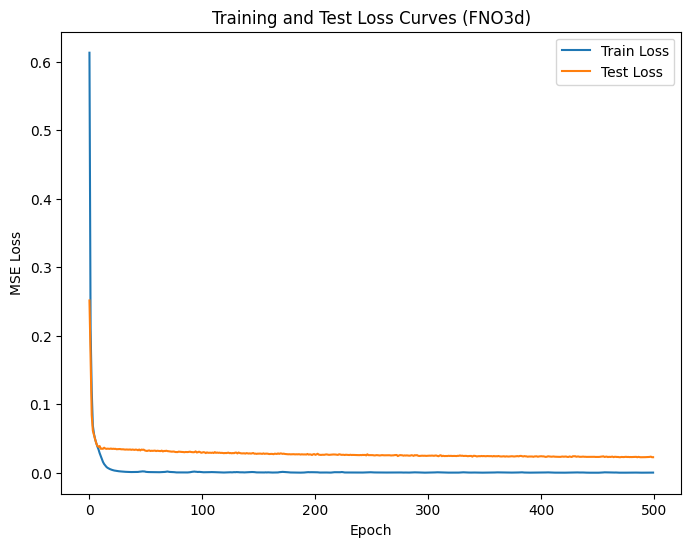

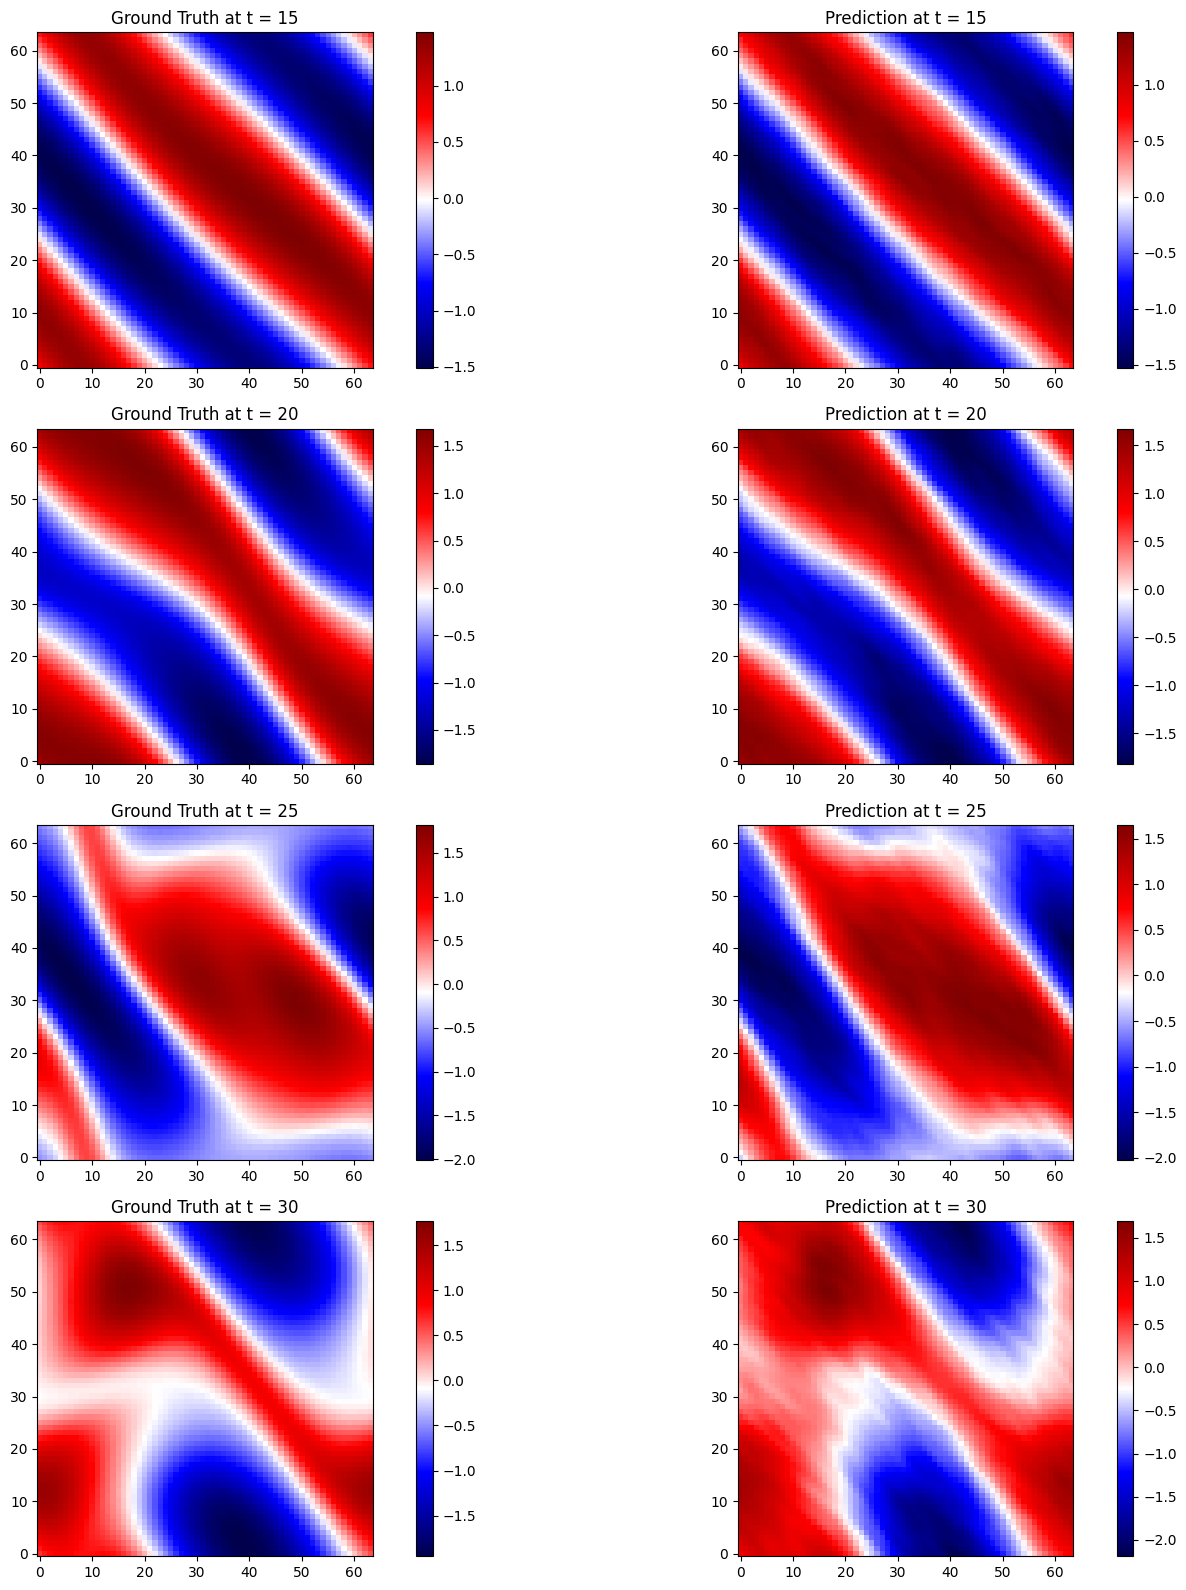

In [5]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation


# =============================================================================
# 1. Navier–Stokes PDE solver (pseudo-spectral method)
# =============================================================================
def solve_navier_stokes(w0, nu, dt, t_final, N):
    """
    2D Navier–Stokes vorticity PDE (주기적 경계조건) 를 푸는 간단한 pseudo-spectral solver.
    
    PDE:
        ∂ₜw + u · ∇w = ν ∆w + f(x)
        u = (ψ_y, -ψ_x),   and   ∆ψ = -w,  with periodic boundary conditions.
    입력:
        w0: 초기 vorticity, shape (N, N)
        nu: 점성 계수
        dt: 시간 스텝
        t_final: 최종 시간
        N: 격자 크기 (N×N)
    출력:
        snapshots: 정수 시간마다 (t, w) 튜플 리스트.
    """
    # 공간 좌표 생성 (0 ≤ x,y < 1)
    x = np.linspace(0, 1, N, endpoint=False)
    y = np.linspace(0, 1, N, endpoint=False)
    xv, yv = np.meshgrid(x, y, indexing='ij')
    
    # forcing function: f(x) = 0.1*( sin(2π(x+y)) + cos(2π(x+y)) )
    f = 0.1 * (np.sin(2*np.pi*(xv + yv)) + np.cos(2*np.pi*(xv + yv)))
    
    # FFT frequencies (주기적 도메인: [0,1])
    kx = np.fft.fftfreq(N, d=1.0/N) * 2*np.pi
    ky = np.fft.fftfreq(N, d=1.0/N) * 2*np.pi
    kx, ky = np.meshgrid(kx, ky, indexing='ij')
    ksq = kx**2 + ky**2
    ksq[0,0] = 1.0  # 0분할 방지
    
    w = w0.copy()
    snapshots = []
    snapshot_times = np.arange(0, t_final+dt, 1.0)  # 정수 시간마다 기록
    next_snapshot_index = 0
    
    nsteps = int(t_final/dt)
    for step in range(nsteps):
        t = step * dt
        # 스냅샷 기록
        if next_snapshot_index < len(snapshot_times) and t >= snapshot_times[next_snapshot_index]:
            snapshots.append((t, w.copy()))
            next_snapshot_index += 1
        
        # vorticity의 FFT
        w_hat = np.fft.fft2(w)
        # stream function: ∆ψ = -w  ->  ψ_hat = -w_hat / ksq, ψ_hat(0)=0
        psi_hat = -w_hat / ksq
        psi_hat[0,0] = 0.0
        psi = np.real(np.fft.ifft2(psi_hat))
        
        # 속도 계산: u = ψ_y, v = -ψ_x (spectral differentiation)
        u = np.real(np.fft.ifft2(1j * ky * psi_hat))
        v = -np.real(np.fft.ifft2(1j * kx * psi_hat))
        
        # vorticity gradient (spectral differentiation)
        w_x = np.real(np.fft.ifft2(1j * kx * w_hat))
        w_y = np.real(np.fft.ifft2(1j * ky * w_hat))
        
        # 비선형 항: u * w_x + v * w_y
        nonlinear = u * w_x + v * w_y
        
        # Laplacian: ∆w = ifft2(-ksq * w_hat)
        lap_w = np.real(np.fft.ifft2(-ksq * w_hat))
        
        # Euler explicit time stepping
        w = w + dt * (-nonlinear + nu * lap_w + f)
    
    return snapshots

    
# =============================================================================
# 2. Navier-Stokes 데이터셋 (PDE solver를 사용하여 데이터 생성)
# =============================================================================
class NavierStokesDatasetFromSolver(Dataset):
    def __init__(self, num_samples, N, dt, t_final, nu, T_in_range, T_out_times):
        """
        num_samples: 샘플 개수.
        N: 공간 격자 크기 (N×N).
        dt: 시간 스텝.
        t_final: 최종 시각 (예, 30).
        nu: 점성 계수.
        T_in_range: 입력 시간 구간 (예: (0, 10)).
        T_out_times: 타겟 시간 (예: [15, 20, 25, 30]).
        """
        self.samples = []
        for i in range(num_samples):
            # 랜덤 초기 조건 (예: 가우시안 랜덤 필드)
            w0 = np.random.randn(N, N)
            snapshots = solve_navier_stokes(w0, nu, dt, t_final, N)
            # snapshots: [(t, w), ...] t는 정수 시간 (0,1,2,...,t_final)
            input_series = []
            for t, w in snapshots:
                if t >= T_in_range[0] and t <= T_in_range[1]:
                    input_series.append(w)
            input_series = np.array(input_series)  # shape: (T_in, N, N)
            
            target_series = []
            for t, w in snapshots:
                if t in T_out_times:
                    target_series.append(w)
            target_series = np.array(target_series)  # shape: (T_out, N, N)
            self.samples.append((input_series, target_series))
        
        # 공간 좌표 (x, y) 생성, x,y ∈ [0,1)
        x = np.linspace(0, 1, N, endpoint=False)
        y = np.linspace(0, 1, N, endpoint=False)
        xv, yv = np.meshgrid(x, y, indexing='ij')
        self.spatial_coords = np.stack([xv, yv], axis=-1)  # (N, N, 2)
        # 입력 시간 좌표: 정수 시간 (예: 0,1,...,10)
        self.input_times = np.arange(T_in_range[0], T_in_range[1]+1)
        self.target_times = np.array(T_out_times)
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        input_series, target_series = self.samples[idx]
        T_in = input_series.shape[0]
        N = input_series.shape[1]
        # 각 입력 시간(t)에 대해 [vorticity, t, x, y]를 결합
        input_data = []
        for i, t in enumerate(self.input_times):
            t_field = np.full((N, N, 1), t)
            w_field = input_series[i][:, :, np.newaxis]
            combined = np.concatenate([w_field, t_field, self.spatial_coords], axis=-1)
            input_data.append(combined)
        input_data = np.stack(input_data, axis=0)  # shape: (T_in, N, N, 4)
        
        # target_series의 길이가 기대하는 T_out와 같지 않은 경우, 부족한 부분을 마지막 스냅샷으로 패딩
        if target_series.shape[0] < len(self.target_times):
            pad_len = len(self.target_times) - target_series.shape[0]
            last = target_series[-1:,...]
            pad = np.repeat(last, pad_len, axis=0)
            target_series = np.concatenate([target_series, pad], axis=0)
        
        target_data = []
        for i in range(target_series.shape[0]):
            target_data.append(target_series[i][:, :, np.newaxis])
        target_data = np.stack(target_data, axis=0)  # shape: (T_out, N, N, 1)
        
        # Torch tensor로 변환
        input_data = torch.tensor(input_data, dtype=torch.float32)
        target_data = torch.tensor(target_data, dtype=torch.float32)
        return input_data, target_data


# =============================================================================
# 3. 기존의 FNO 모델 (3D FNO: 시간-공간 연산자 학습)
# =============================================================================
class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes_t, modes_x, modes_y):
        super(SpectralConv3d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes_t = modes_t
        self.modes_x = modes_x
        self.modes_y = modes_y
        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, modes_t, modes_x, modes_y, 2)
        )
    
    def compl_mul3d(self, input, weights):
        # weights: (in_channels, out_channels, t, x, y, 2) -> 복소수 텐서: (in_channels, out_channels, t, x, y)
        weight_complex = torch.view_as_complex(weights)
        # "bctxy, cotxy -> botxy": 입력의 각 주파수에 대해, C_in에 대해 합산하여 (batch, out_channels, t, x, y)를 얻음.
        return torch.einsum("bctxy, cotxy -> botxy", input, weight_complex)
    
    def forward(self, x):
        batchsize = x.shape[0]
        # 3D FFT 계산: x의 shape은 (batch, in_channels, t, x, y)
        x_ft = torch.fft.rfftn(x, dim=[2,3,4])
        out_ft = torch.zeros(
            batchsize, self.out_channels, x_ft.size(2), x_ft.size(3), x_ft.size(4),
            device=x.device, dtype=torch.cfloat
        )
        t_modes = min(self.modes_t, x_ft.size(2))
        x_modes = min(self.modes_x, x_ft.size(3))
        y_modes = min(self.modes_y, x_ft.size(4))
        out_ft[:, :, :t_modes, :x_modes, :y_modes] = self.compl_mul3d(
            x_ft[:, :, :t_modes, :x_modes, :y_modes],
            self.weights[:, :, :t_modes, :x_modes, :y_modes]
        )
        x = torch.fft.irfftn(out_ft, s=(x.size(2), x.size(3), x.size(4)))
        return x



class FNO3d(nn.Module):
    def __init__(self, modes_t, modes_x, modes_y, width, T_in, T_out):
        """
        modes_t, modes_x, modes_y: 시간 및 공간 방향의 Fourier 모드 수.
        width: latent channel 차원.
        T_in: 입력 시간 스텝 수 (예: 11, t=0~10)
        T_out: 출력 시간 스텝 수 (예: 4, t=15,20,25,30)
        """
        super(FNO3d, self).__init__()
        self.width = width
        self.T_in = T_in
        self.T_out = T_out
        self.fc0 = nn.Linear(4, width)  # 입력 채널: [vorticity, t, x, y]
        
        self.conv0 = SpectralConv3d(self.width, self.width, modes_t, modes_x, modes_y)
        self.conv1 = SpectralConv3d(self.width, self.width, modes_t, modes_x, modes_y)
        self.conv2 = SpectralConv3d(self.width, self.width, modes_t, modes_x, modes_y)
        self.conv3 = SpectralConv3d(self.width, self.width, modes_t, modes_x, modes_y)
        
        self.w0 = nn.Conv3d(self.width, self.width, 1)
        self.w1 = nn.Conv3d(self.width, self.width, 1)
        self.w2 = nn.Conv3d(self.width, self.width, 1)
        self.w3 = nn.Conv3d(self.width, self.width, 1)
        
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)  # 출력: vorticity
        
        # Temporal predictor: 각 픽셀별로 입력 시간(T_in)을 출력 시간(T_out)으로 매핑
        self.temporal_fc = nn.Linear(T_in, T_out)
        
    def forward(self, x):
        # x: (batch, T_in, H, W, 4)
        batch, T_in, H, W, _ = x.shape
        x = self.fc0(x)  # (batch, T_in, H, W, width)
        x = x.permute(0, 4, 1, 2, 3)  # (batch, width, T_in, H, W)
        
        x0 = self.conv0(x)
        x1 = self.w0(x)
        x = F.gelu(x0 + x1)
        
        x0 = self.conv1(x)
        x1 = self.w1(x)
        x = F.gelu(x0 + x1)
        
        x0 = self.conv2(x)
        x1 = self.w2(x)
        x = F.gelu(x0 + x1)
        
        x0 = self.conv3(x)
        x1 = self.w3(x)
        x = F.gelu(x0 + x1)
        
        x = x.permute(0, 2, 3, 4, 1)  # (batch, T_in, H, W, width)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)  # (batch, T_in, H, W, 1)
        
        # Temporal prediction: 각 픽셀별로 입력 시간 차원(T_in)을 T_out 차원으로 변환
        x = x.squeeze(-1)              # (batch, T_in, H, W)
        x = x.permute(0, 2, 3, 1)        # (batch, H, W, T_in)
        x = self.temporal_fc(x)          # (batch, H, W, T_out)
        x = x.permute(0, 3, 1, 2).unsqueeze(-1)  # (batch, T_out, H, W, 1)
        return x


# =============================================================================
# 4. 학습 루프 및 시각화
# =============================================================================
def train_model_3d(model, train_loader, test_loader, epochs=300):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
    loss_fn = nn.MSELoss()
    train_losses = []
    test_losses = []
    
    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0.0
        for input_data, target in train_loader:
            # input_data: (batch, T_in, H, W, 4), target: (batch, T_out, H, W, 1)
            input_data = input_data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(input_data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * input_data.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for input_data, target in test_loader:
                input_data = input_data.to(device)
                target = target.to(device)
                output = model(input_data)
                loss = loss_fn(output, target)
                test_loss += loss.item() * input_data.size(0)
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        #scheduler.step()
        if epoch % 1 == 0:
            print(f"Epoch {epoch:03d}: Train Loss = {train_loss:.6f}, Test Loss = {test_loss:.6f}")
    
    plt.figure(figsize=(8,6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.title("Training and Test Loss Curves (FNO3d)")
    plt.show()
    
    return train_losses, test_losses

def visualize_sample_3d(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        input_data, target = next(iter(test_loader))
        input_data = input_data.to(device)
        pred = model(input_data)
    sample_target = target[0].cpu().numpy()  # (T_out, H, W, 1)
    sample_pred = pred[0].cpu().numpy()      # (T_out, H, W, 1)
    times = [15, 20, 25, 30]  # target 시간 라벨
    T_out = sample_target.shape[0]
    plt.figure(figsize=(16, 4*T_out))
    for i in range(T_out):
        plt.subplot(T_out, 2, 2*i+1)
        plt.title(f"Ground Truth at t = {times[i]}")
        plt.imshow(sample_target[i, :, :, 0], cmap="seismic", origin="lower")
        plt.colorbar()
        plt.subplot(T_out, 2, 2*i+2)
        plt.title(f"Prediction at t = {times[i]}")
        plt.imshow(sample_pred[i, :, :, 0], cmap="seismic", origin="lower")
        plt.colorbar()
    plt.tight_layout()
    plt.show()


# =============================================================================
# 5. 전체 파이프라인 실행
# =============================================================================
if __name__ == '__main__':
    # PDE simulation parameters
    N = 64         # spatial resolution: 64x64
    dt = 0.005     # 시간 스텝 (안정성을 위해 충분히 작게)
    t_final = 50   # 최종 시각
    nu = 1e-3      # 점성 계수 (예시)
    
    # 데이터셋에서 사용할 시간 구간
    T_in_range = (0, 10)          # 입력: t=0 ~ 10 (정수 시간 스냅샷)
    T_out_times = [20, 30, 40, 49] # 타겟: t = 15,20,25,30
    
    num_train = 100   # 시연을 위한 샘플 수 (실제 연구에서는 더 많은 샘플 사용)
    num_test = 20
    
    # Navier–Stokes PDE solver를 통해 데이터 생성
    dataset_solver_train = NavierStokesDatasetFromSolver(num_samples=num_train, N=N, dt=dt, t_final=t_final, nu=nu, 
                                                          T_in_range=T_in_range, T_out_times=T_out_times)
    dataset_solver_test  = NavierStokesDatasetFromSolver(num_samples=num_test, N=N, dt=dt, t_final=t_final, nu=nu, 
                                                          T_in_range=T_in_range, T_out_times=T_out_times)
    
    train_loader = DataLoader(dataset_solver_train, batch_size=2, shuffle=True)
    test_loader = DataLoader(dataset_solver_test, batch_size=2, shuffle=False)
    
    # 모델 하이퍼파라미터: Fourier 모드 수 선택 (시간: 4, x: 16, y: 16), width: 32, T_out: 4
    modes_t, modes_x, modes_y = 4, 16, 16
    width = 32
    T_out = len(T_out_times)
    T_in = 11
    model = FNO3d(modes_t, modes_x, modes_y, width, T_in, T_out)
    
    # 학습
    train_losses, test_losses = train_model_3d(model, train_loader, test_loader, epochs=500)
    
    # 결과 시각화
    visualize_sample_3d(model, test_loader)
    

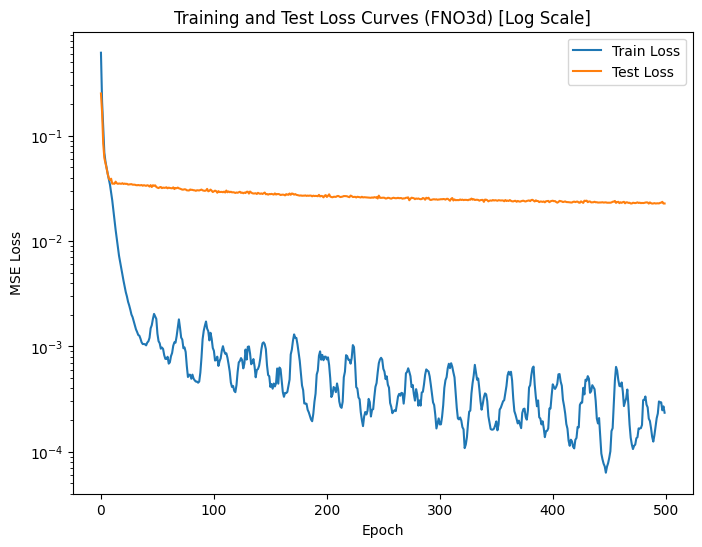

In [6]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.yscale('log')
plt.legend()
plt.title("Training and Test Loss Curves (FNO3d) [Log Scale]")
plt.show()


In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# =============================================================================
# 1. Navier–Stokes PDE solver (pseudo-spectral method)
# =============================================================================
def solve_navier_stokes(w0, nu, dt, t_final, N):
    """
    2D Navier–Stokes vorticity PDE (주기적 경계조건) 를 푸는 간단한 pseudo-spectral solver.
    
    PDE:
        ∂ₜw + u · ∇w = ν ∆w + f(x)
        u = (ψ_y, -ψ_x),   and   ∆ψ = -w,  with periodic boundary conditions.
    입력:
        w0: 초기 vorticity, shape (N, N)
        nu: 점성 계수
        dt: 시간 스텝
        t_final: 최종 시간
        N: 격자 크기 (N×N)
    출력:
        snapshots: 정수 시간마다 (t, w) 튜플 리스트.
    """
    x = np.linspace(0, 1, N, endpoint=False)
    y = np.linspace(0, 1, N, endpoint=False)
    xv, yv = np.meshgrid(x, y, indexing='ij')
    f = 0.1 * (np.sin(2*np.pi*(xv + yv)) + np.cos(2*np.pi*(xv + yv)))
    kx = np.fft.fftfreq(N, d=1.0/N) * 2*np.pi
    ky = np.fft.fftfreq(N, d=1.0/N) * 2*np.pi
    kx, ky = np.meshgrid(kx, ky, indexing='ij')
    ksq = kx**2 + ky**2
    ksq[0,0] = 1.0
    w = w0.copy()
    snapshots = []
    snapshot_times = np.arange(0, t_final+dt, 1.0)
    next_snapshot_index = 0
    nsteps = int(t_final/dt)
    for step in range(nsteps):
        t = step * dt
        if next_snapshot_index < len(snapshot_times) and t >= snapshot_times[next_snapshot_index]:
            snapshots.append((t, w.copy()))
            next_snapshot_index += 1
        w_hat = np.fft.fft2(w)
        psi_hat = -w_hat / ksq
        psi_hat[0,0] = 0.0
        psi = np.real(np.fft.ifft2(psi_hat))
        u = np.real(np.fft.ifft2(1j * ky * psi_hat))
        v = -np.real(np.fft.ifft2(1j * kx * psi_hat))
        w_x = np.real(np.fft.ifft2(1j * kx * w_hat))
        w_y = np.real(np.fft.ifft2(1j * ky * w_hat))
        nonlinear = u * w_x + v * w_y
        lap_w = np.real(np.fft.ifft2(-ksq * w_hat))
        w = w + dt * (-nonlinear + nu * lap_w + f)
    return snapshots

# =============================================================================
# 2. Navier-Stokes 데이터셋 (PDE solver를 사용하여 데이터 생성)
# =============================================================================
class NavierStokesDatasetFromSolver(Dataset):
    def __init__(self, num_samples, N, dt, t_final, nu, T_in_range, T_out_times):
        self.samples = []
        for i in range(num_samples):
            w0 = np.random.randn(N, N)
            snapshots = solve_navier_stokes(w0, nu, dt, t_final, N)
            input_series = []
            for t, w in snapshots:
                if t >= T_in_range[0] and t <= T_in_range[1]:
                    input_series.append(w)
            input_series = np.array(input_series)  # (T_in, N, N)
            target_series = []
            for t, w in snapshots:
                if t in T_out_times:
                    target_series.append(w)
            target_series = np.array(target_series)  # (T_out, N, N)
            self.samples.append((input_series, target_series))
        x = np.linspace(0, 1, N, endpoint=False)
        y = np.linspace(0, 1, N, endpoint=False)
        xv, yv = np.meshgrid(x, y, indexing='ij')
        self.spatial_coords = np.stack([xv, yv], axis=-1)  # (N, N, 2)
        self.input_times = np.arange(T_in_range[0], T_in_range[1]+1)
        self.target_times = np.array(T_out_times)
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        input_series, target_series = self.samples[idx]
        T_in = input_series.shape[0]
        N = input_series.shape[1]
        input_data = []
        for i, t in enumerate(self.input_times):
            t_field = np.full((N, N, 1), t)
            w_field = input_series[i][:, :, np.newaxis]
            combined = np.concatenate([w_field, t_field, self.spatial_coords], axis=-1)
            input_data.append(combined)
        input_data = np.stack(input_data, axis=0)  # (T_in, N, N, 4)
        if target_series.shape[0] < len(self.target_times):
            pad_len = len(self.target_times) - target_series.shape[0]
            last = target_series[-1:,...]
            pad = np.repeat(last, pad_len, axis=0)
            target_series = np.concatenate([target_series, pad], axis=0)
        target_data = []
        for i in range(target_series.shape[0]):
            target_data.append(target_series[i][:, :, np.newaxis])
        target_data = np.stack(target_data, axis=0)  # (T_out, N, N, 1)
        input_data = torch.tensor(input_data, dtype=torch.float32)
        target_data = torch.tensor(target_data, dtype=torch.float32)
        return input_data, target_data

# =============================================================================
# 3. FNO 모델 (3D FNO: 시간-공간 연산자 학습) with Physics-Informed Loss
# =============================================================================
class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes_t, modes_x, modes_y):
        super(SpectralConv3d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes_t = modes_t
        self.modes_x = modes_x
        self.modes_y = modes_y
        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, modes_t, modes_x, modes_y, 2)
        )
    
    def compl_mul3d(self, input, weights):
        weight_complex = torch.view_as_complex(weights)
        return torch.einsum("bctxy, cotxy -> botxy", input, weight_complex)
    
    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfftn(x, dim=[2,3,4])
        out_ft = torch.zeros(
            batchsize, self.out_channels, x_ft.size(2), x_ft.size(3), x_ft.size(4),
            device=x.device, dtype=torch.cfloat
        )
        t_modes = min(self.modes_t, x_ft.size(2))
        x_modes = min(self.modes_x, x_ft.size(3))
        y_modes = min(self.modes_y, x_ft.size(4))
        out_ft[:, :, :t_modes, :x_modes, :y_modes] = self.compl_mul3d(
            x_ft[:, :, :t_modes, :x_modes, :y_modes],
            self.weights[:, :, :t_modes, :x_modes, :y_modes]
        )
        x = torch.fft.irfftn(out_ft, s=(x.size(2), x.size(3), x.size(4)))
        return x


class FNO3d(nn.Module):
    def __init__(self, modes_t, modes_x, modes_y, width, T_in, T_out):
        """
        modes_t, modes_x, modes_y: 시간 및 공간 방향의 Fourier 모드 수.
        width: latent channel 차원.
        T_in: 입력 시간 스텝 수 (예: 11, t=0~10)
        T_out: 출력 시간 스텝 수 (예: 4, t=15,20,25,30)
        """
        super(FNO3d, self).__init__()
        self.width = width
        self.T_in = T_in
        self.T_out = T_out
        self.fc0 = nn.Linear(4, width)  # 입력 채널: [vorticity, t, x, y]
        
        self.conv0 = SpectralConv3d(self.width, self.width, modes_t, modes_x, modes_y)
        self.conv1 = SpectralConv3d(self.width, self.width, modes_t, modes_x, modes_y)
        self.conv2 = SpectralConv3d(self.width, self.width, modes_t, modes_x, modes_y)
        self.conv3 = SpectralConv3d(self.width, self.width, modes_t, modes_x, modes_y)
        
        self.w0 = nn.Conv3d(self.width, self.width, 1)
        self.w1 = nn.Conv3d(self.width, self.width, 1)
        self.w2 = nn.Conv3d(self.width, self.width, 1)
        self.w3 = nn.Conv3d(self.width, self.width, 1)
        
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)  # 출력: vorticity
        
        # Temporal predictor: 각 픽셀별로 입력 시간(T_in)을 출력 시간(T_out)으로 매핑
        self.temporal_fc = nn.Linear(T_in, T_out)
        
    def forward(self, x):
        # x: (batch, T_in, H, W, 4)
        batch, T_in, H, W, _ = x.shape
        x = self.fc0(x)  # (batch, T_in, H, W, width)
        x = x.permute(0, 4, 1, 2, 3)  # (batch, width, T_in, H, W)
        
        x0 = self.conv0(x)
        x1 = self.w0(x)
        x = F.gelu(x0 + x1)
        
        x0 = self.conv1(x)
        x1 = self.w1(x)
        x = F.gelu(x0 + x1)
        
        x0 = self.conv2(x)
        x1 = self.w2(x)
        x = F.gelu(x0 + x1)
        
        x0 = self.conv3(x)
        x1 = self.w3(x)
        x = F.gelu(x0 + x1)
        
        x = x.permute(0, 2, 3, 4, 1)  # (batch, T_in, H, W, width)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)  # (batch, T_in, H, W, 1)
        
        # Temporal prediction: 각 픽셀별로 입력 시간 차원(T_in)을 T_out 차원으로 변환
        x = x.squeeze(-1)              # (batch, T_in, H, W)
        x = x.permute(0, 2, 3, 1)        # (batch, H, W, T_in)
        x = self.temporal_fc(x)          # (batch, H, W, T_out)
        x = x.permute(0, 3, 1, 2).unsqueeze(-1)  # (batch, T_out, H, W, 1)
        return x

# =============================================================================
# Physics-Informed Loss 구성
# =============================================================================
def compute_PDE_loss(pred, nu, dt, dx, dy):
    """
    pred: (batch, T_out, H, W, 1) 예측된 vorticity (미분 가능한 텐서)
    PDE: ∂ₜw + u·∇w = ν Δw + f(x)
    여기서 f(x) = 0.1*( sin(2π(x+y)) + cos(2π(x+y)) )
    
    finite difference를 사용해 시간 및 공간 미분을 계산하고, residual의 MSE를 PDE loss로 반환합니다.
    """
    batch, T_out, H, W, _ = pred.shape
    pred = pred.squeeze(-1)  # (batch, T_out, H, W)
    
    # 공간 좌표 생성 (1차원 텐서로)
    device = pred.device
    x = torch.linspace(0, 1, W, device=device).view(1, 1, 1, W).expand(batch, T_out, H, W)
    y = torch.linspace(0, 1, H, device=device).view(1, 1, H, 1).expand(batch, T_out, H, W)
    f_val = 0.1 * (torch.sin(2*np.pi*(x+y)) + torch.cos(2*np.pi*(x+y)))  # (batch, T_out, H, W)
    
    loss_pde = 0.0
    count = 0
    # 시간 미분: forward difference, t=0,...,T_out-2
    for t in range(T_out-1):
        w_t = (pred[:, t+1, :, :] - pred[:, t, :, :]) / dt  # (batch, H, W)
        w = pred[:, t, :, :]  # (batch, H, W)
        # 공간 중앙 차분 (주기적 경계 조건)
        w_x = (torch.roll(w, shifts=-1, dims=3) - torch.roll(w, shifts=1, dims=3)) / (2*dx)
        w_y = (torch.roll(w, shifts=-1, dims=2) - torch.roll(w, shifts=1, dims=2)) / (2*dy)
        # Laplacian (중심 차분)
        w_xx = (torch.roll(w, shifts=-1, dims=3) - 2*w + torch.roll(w, shifts=1, dims=3)) / (dx**2)
        w_yy = (torch.roll(w, shifts=-1, dims=2) - 2*w + torch.roll(w, shifts=1, dims=2)) / (dy**2)
        lap = w_xx + w_yy
        # FFT 기반으로 계산한 속도 (autograd 지원)
        u, v = compute_velocity_torch(w)
        adv = u * w_x + v * w_y
        r = w_t + adv - nu * lap - f_val[:, t, :, :]
        loss_pde += torch.mean(r**2)
        count += 1
    return loss_pde / count

def compute_BC_loss(pred):
    """
    pred: (batch, T_out, H, W, 1)
    주기적 경계 조건을 강제하기 위해, 좌우 및 상하 경계에서의 값 차이를 최소화합니다.
    """
    batch, T_out, H, W, _ = pred.shape
    pred = pred.squeeze(-1)  # (batch, T_out, H, W)
    loss_bc = 0.0
    # 좌우 경계: x=0과 x=W-1
    bc_left = pred[:, :, :, 0]
    bc_right = pred[:, :, :, -1]
    loss_bc += torch.mean((bc_left - bc_right)**2)
    # 상하 경계: y=0과 y=H-1
    bc_top = pred[:, :, 0, :]
    bc_bottom = pred[:, :, -1, :]
    loss_bc += torch.mean((bc_top - bc_bottom)**2)
    return loss_bc

def compute_IC_loss(pred, ic):
    """
    pred: (batch, T_out, H, W, 1) 예측된 초기 해 (예: 예측된 예측 영역의 첫 프레임)
    ic: (batch, H, W, 1) 주어진 초기 조건 (예: 타겟의 첫 프레임)
    """
    # 간단히 MSE로 구성
    return F.mse_loss(pred[:,0,:,:,:], ic)

def compute_velocity_torch(w):
    """
    w: (batch, H, W)
    FFT를 이용해 stream function ψ를 구한 뒤, u = ψ_y, v = -ψ_x를 계산합니다.
    """
    batch, H, W = w.shape
    device = w.device
    kx = torch.fft.fftfreq(H, d=1.0/H).to(device) * 2 * np.pi
    ky = torch.fft.fftfreq(W, d=1.0/W).to(device) * 2 * np.pi
    kx, ky = torch.meshgrid(kx, ky, indexing='ij')
    kx = kx.unsqueeze(0)  # (1, H, W)
    ky = ky.unsqueeze(0)  # (1, H, W)
    ksq = kx**2 + ky**2
    ksq[0,0,0] = 1.0
    w_hat = torch.fft.fft2(w)
    psi_hat = -w_hat / ksq
    psi_hat[:,0,0] = 0.0
    psi = torch.real(torch.fft.ifft2(psi_hat))
    u_hat = 1j * ky * psi_hat
    v_hat = -1j * kx * psi_hat
    u = torch.real(torch.fft.ifft2(u_hat))
    v = torch.real(torch.fft.ifft2(v_hat))
    return u, v

# =============================================================================
# 4. 학습 루프 및 시각화 (Physics-Informed Loss 포함)
# =============================================================================
def train_model_3d(model, train_loader, test_loader, epochs=300, lambda_pde=1.0, lambda_bc=1.0, lambda_ic=1.0, dt_out=1.0):
    """
    lambda_pde: PDE loss의 가중치.
    lambda_bc: Boundary Condition loss의 가중치.
    lambda_ic: Initial Condition loss의 가중치.
    dt_out: 출력 시간 간격 (타겟 시간이 정수일 경우 1.0)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
    loss_fn = nn.MSELoss()
    train_losses = []
    test_losses = []
    
    # 공간 간격 (도메인이 [0,1])
    H = 64
    W = 64
    dx = 1.0 / W
    dy = 1.0 / H
    
    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        for input_data, target in train_loader:
            # input_data: (batch, T_in, H, W, 4), target: (batch, T_out, H, W, 1)
            input_data = input_data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(input_data)  # (batch, T_out, H, W, 1)
            loss_data = loss_fn(output, target)
            loss_pde = compute_PDE_loss(output, nu, dt_out, dx, dy)
            loss_bc = compute_BC_loss(output)
            # IC loss: 여기서는 타겟의 첫 프레임을 초기 조건으로 사용
            loss_ic = compute_IC_loss(output, target)
            loss = loss_data + lambda_pde * loss_pde + lambda_bc * loss_bc + lambda_ic * loss_ic
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * input_data.size(0)
        total_loss /= len(train_loader.dataset)
        train_losses.append(total_loss)
        
        model.eval()
        total_loss_test = 0.0
        with torch.no_grad():
            for input_data, target in test_loader:
                input_data = input_data.to(device)
                target = target.to(device)
                output = model(input_data)
                loss_data = loss_fn(output, target)
                loss_pde = compute_PDE_loss(output, nu, dt_out, dx, dy)
                loss_bc = compute_BC_loss(output)
                loss_ic = compute_IC_loss(output, target)
                loss = loss_data + lambda_pde * loss_pde + lambda_bc * loss_bc + lambda_ic * loss_ic
                total_loss_test += loss.item() * input_data.size(0)
        total_loss_test /= len(test_loader.dataset)
        test_losses.append(total_loss_test)
        scheduler.step()
        print(f"Epoch {epoch:03d}: Train Loss = {total_loss:.6f}, Test Loss = {total_loss_test:.6f}")
    
    plt.figure(figsize=(8,6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Total Loss")
    plt.legend()
    plt.title("Training and Test Loss Curves (FNO3d with Physics Loss)")
    plt.show()
    
    return train_losses, test_losses

def animate_continuous_motion(model, test_loader, num_interp=10, save_path='continuous_motion.gif'):
    """
    테스트 데이터셋의 첫 번째 샘플에 대해, ground truth와 FNO 모델의 예측 결과의 
    시간에 따른 변화를 연속 애니메이션으로 생성하여 .gif 파일로 저장합니다.
    
    model 출력과 타겟 텐서의 shape은 (batch, T_out, H, W, 1)이어야 합니다.
    num_interp: 인접 스냅샷 사이에 생성할 보간 프레임 수.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        input_data, target = next(iter(test_loader))
        input_data = input_data.to(device)
        pred = model(input_data)  # (batch, T_out, H, W, 1)
    
    sample_pred = pred[0].cpu().numpy().squeeze(-1)    # (T_out, H, W)
    sample_target = target[0].cpu().numpy().squeeze(-1)  # (T_out, H, W)
    T_out = sample_pred.shape[0]
    
    def interpolate_frames(frames, num_interp):
        T, H, W = frames.shape
        interp_frames = []
        for i in range(T - 1):
            for alpha in np.linspace(0, 1, num_interp, endpoint=False):
                interp_frames.append((1 - alpha) * frames[i] + alpha * frames[i+1])
        interp_frames.append(frames[-1])
        return np.array(interp_frames)
    
    interp_target = interpolate_frames(sample_target, num_interp)
    interp_pred = interpolate_frames(sample_pred, num_interp)
    total_frames = interp_target.shape[0]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    im1 = ax1.imshow(interp_target[0], cmap="RdBu", origin="lower")
    ax1.set_title("Ground Truth (frame 1)")
    plt.colorbar(im1, ax=ax1)
    
    im2 = ax2.imshow(interp_pred[0], cmap="RdBu", origin="lower")
    ax2.set_title("Prediction (frame 1)")
    plt.colorbar(im2, ax=ax2)
    
    def update(frame):
        im1.set_data(interp_target[frame])
        im2.set_data(interp_pred[frame])
        ax1.set_title(f"Ground Truth (frame {frame+1}/{total_frames})")
        ax2.set_title(f"Prediction (frame {frame+1}/{total_frames})")
        return [im1, im2]
    
    ani = animation.FuncAnimation(fig, update, frames=total_frames, interval=100, blit=True)
    writer = animation.PillowWriter(fps=10)
    ani.save(save_path, writer=writer)
    print("Animation saved as", save_path)
    plt.close(fig)
    return ani

# =============================================================================
# 5. 전체 파이프라인 실행
# =============================================================================
if __name__ == '__main__':
    N = 64         
    dt = 0.005     
    t_final = 50   
    nu = 1e-3      
    T_in_range = (0, 10)          
    T_out_times = [20, 30, 40, 49] 
    num_train = 20  
    num_test = 4
    
    dataset_solver_train = NavierStokesDatasetFromSolver(num_samples=num_train, N=N, dt=dt, t_final=t_final, nu=nu, 
                                                          T_in_range=T_in_range, T_out_times=T_out_times)
    dataset_solver_test  = NavierStokesDatasetFromSolver(num_samples=num_test, N=N, dt=dt, t_final=t_final, nu=nu, 
                                                          T_in_range=T_in_range, T_out_times=T_out_times)
    
    train_loader = DataLoader(dataset_solver_train, batch_size=2, shuffle=True)
    test_loader = DataLoader(dataset_solver_test, batch_size=2, shuffle=False)
    
    modes_t, modes_x, modes_y = 4, 16, 16
    width = 32
    T_out = len(T_out_times)
    T_in = len(np.arange(T_in_range[0], T_in_range[1]+1))  
    model = FNO3d(modes_t, modes_x, modes_y, width, T_in, T_out)
    
    train_losses, test_losses = train_model_3d(model, train_loader, test_loader, epochs=500, lambda_pde=1.0, lambda_bc=1.0, lambda_ic=1.0, dt_out=1.0)
    
    ani = animate_continuous_motion(model, test_loader, num_interp=10, save_path='continuous_motion.gif')


IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt


# =============================================================================
# 1. Navier–Stokes PDE solver (pseudo-spectral method)
# =============================================================================
def solve_navier_stokes(w0, nu, dt, t_final, N):
    """
    2D Navier–Stokes vorticity PDE (주기적 경계조건) 를 푸는 간단한 pseudo-spectral solver.
    
    PDE:
        ∂ₜw + u · ∇w = ν ∆w + f(x)
        u = (ψ_y, -ψ_x),   and   ∆ψ = -w,  with periodic boundary conditions.
    입력:
        w0: 초기 vorticity, shape (N, N)
        nu: 점성 계수
        dt: 시간 스텝
        t_final: 최종 시간
        N: 격자 크기 (N×N)
    출력:
        snapshots: 정수 시간마다 (t, w) 튜플 리스트.
    """
    # 공간 좌표 생성 (0 ≤ x,y < 1)
    x = np.linspace(0, 1, N, endpoint=False)
    y = np.linspace(0, 1, N, endpoint=False)
    xv, yv = np.meshgrid(x, y, indexing='ij')
    
    # forcing function: f(x) = 0.1*( sin(2π(x+y)) + cos(2π(x+y)) )
    f = 0.1 * (np.sin(2*np.pi*(xv + yv)) + np.cos(2*np.pi*(xv + yv)))
    
    # FFT frequencies (주기적 도메인: [0,1])
    kx = np.fft.fftfreq(N, d=1.0/N) * 2*np.pi
    ky = np.fft.fftfreq(N, d=1.0/N) * 2*np.pi
    kx, ky = np.meshgrid(kx, ky, indexing='ij')
    ksq = kx**2 + ky**2
    ksq[0,0] = 1.0  # 0분할 방지
    
    w = w0.copy()
    snapshots = []
    snapshot_times = np.arange(0, t_final+dt, 1.0)  # 정수 시간마다 기록
    next_snapshot_index = 0
    
    nsteps = int(t_final/dt)
    for step in range(nsteps):
        t = step * dt
        # 스냅샷 기록
        if next_snapshot_index < len(snapshot_times) and t >= snapshot_times[next_snapshot_index]:
            snapshots.append((t, w.copy()))
            next_snapshot_index += 1
        
        # vorticity의 FFT
        w_hat = np.fft.fft2(w)
        # stream function: ∆ψ = -w  ->  ψ_hat = -w_hat / ksq, ψ_hat(0)=0
        psi_hat = -w_hat / ksq
        psi_hat[0,0] = 0.0
        psi = np.real(np.fft.ifft2(psi_hat))
        
        # 속도 계산: u = ψ_y, v = -ψ_x (spectral differentiation)
        u = np.real(np.fft.ifft2(1j * ky * psi_hat))
        v = -np.real(np.fft.ifft2(1j * kx * psi_hat))
        
        # vorticity gradient (spectral differentiation)
        w_x = np.real(np.fft.ifft2(1j * kx * w_hat))
        w_y = np.real(np.fft.ifft2(1j * ky * w_hat))
        
        # 비선형 항: u * w_x + v * w_y
        nonlinear = u * w_x + v * w_y
        
        # Laplacian: ∆w = ifft2(-ksq * w_hat)
        lap_w = np.real(np.fft.ifft2(-ksq * w_hat))
        
        # Euler explicit time stepping
        w = w + dt * (-nonlinear + nu * lap_w + f)
    
    return snapshots

    
# =============================================================================
# 2. Navier-Stokes 데이터셋 (PDE solver를 사용하여 데이터 생성)
# =============================================================================
class NavierStokesDatasetFromSolver(Dataset):
    def __init__(self, num_samples, N, dt, t_final, nu, T_in_range, T_out_times):
        """
        num_samples: 샘플 개수.
        N: 공간 격자 크기 (N×N).
        dt: 시간 스텝.
        t_final: 최종 시각 (예, 30).
        nu: 점성 계수.
        T_in_range: 입력 시간 구간 (예: (0, 10)).
        T_out_times: 타겟 시간 (예: [15, 20, 25, 30]).
        """
        self.samples = []
        for i in range(num_samples):
            # 랜덤 초기 조건 (예: 가우시안 랜덤 필드)
            w0 = np.random.randn(N, N)
            snapshots = solve_navier_stokes(w0, nu, dt, t_final, N)
            # snapshots: [(t, w), ...] t는 정수 시간 (0,1,2,...,t_final)
            input_series = []
            for t, w in snapshots:
                if t >= T_in_range[0] and t <= T_in_range[1]:
                    input_series.append(w)
            input_series = np.array(input_series)  # shape: (T_in, N, N)
            
            target_series = []
            for t, w in snapshots:
                if t in T_out_times:
                    target_series.append(w)
            target_series = np.array(target_series)  # shape: (T_out, N, N)
            self.samples.append((input_series, target_series))
        
        # 공간 좌표 (x, y) 생성, x,y ∈ [0,1)
        x = np.linspace(0, 1, N, endpoint=False)
        y = np.linspace(0, 1, N, endpoint=False)
        xv, yv = np.meshgrid(x, y, indexing='ij')
        self.spatial_coords = np.stack([xv, yv], axis=-1)  # (N, N, 2)
        # 입력 시간 좌표: 정수 시간 (예: 0,1,...,10)
        self.input_times = np.arange(T_in_range[0], T_in_range[1]+1)
        self.target_times = np.array(T_out_times)
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        input_series, target_series = self.samples[idx]
        T_in = input_series.shape[0]
        N = input_series.shape[1]
        # 각 입력 시간(t)에 대해 [vorticity, t, x, y]를 결합
        input_data = []
        for i, t in enumerate(self.input_times):
            t_field = np.full((N, N, 1), t)
            w_field = input_series[i][:, :, np.newaxis]
            combined = np.concatenate([w_field, t_field, self.spatial_coords], axis=-1)
            input_data.append(combined)
        input_data = np.stack(input_data, axis=0)  # shape: (T_in, N, N, 4)
        
        # target_series의 길이가 기대하는 T_out와 같지 않은 경우, 부족한 부분을 마지막 스냅샷으로 패딩
        if target_series.shape[0] < len(self.target_times):
            pad_len = len(self.target_times) - target_series.shape[0]
            last = target_series[-1:,...]
            pad = np.repeat(last, pad_len, axis=0)
            target_series = np.concatenate([target_series, pad], axis=0)
        
        target_data = []
        for i in range(target_series.shape[0]):
            target_data.append(target_series[i][:, :, np.newaxis])
        target_data = np.stack(target_data, axis=0)  # shape: (T_out, N, N, 1)
        
        # Torch tensor로 변환
        input_data = torch.tensor(input_data, dtype=torch.float32)
        target_data = torch.tensor(target_data, dtype=torch.float32)
        return input_data, target_data


# =============================================================================
# 3. 기존의 FNO 모델 (3D FNO: 시간-공간 연산자 학습)
# =============================================================================
class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes_t, modes_x, modes_y):
        super(SpectralConv3d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes_t = modes_t
        self.modes_x = modes_x
        self.modes_y = modes_y
        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, modes_t, modes_x, modes_y, 2)
        )
    
    def compl_mul3d(self, input, weights):
        # weights: (in_channels, out_channels, t, x, y, 2) -> 복소수 텐서: (in_channels, out_channels, t, x, y)
        weight_complex = torch.view_as_complex(weights)
        # "bctxy, cotxy -> botxy": 입력의 각 주파수에 대해, C_in에 대해 합산하여 (batch, out_channels, t, x, y)를 얻음.
        return torch.einsum("bctxy, cotxy -> botxy", input, weight_complex)
    
    def forward(self, x):
        batchsize = x.shape[0]
        # 3D FFT 계산: x의 shape은 (batch, in_channels, t, x, y)
        x_ft = torch.fft.rfftn(x, dim=[2,3,4])
        out_ft = torch.zeros(
            batchsize, self.out_channels, x_ft.size(2), x_ft.size(3), x_ft.size(4),
            device=x.device, dtype=torch.cfloat
        )
        t_modes = min(self.modes_t, x_ft.size(2))
        x_modes = min(self.modes_x, x_ft.size(3))
        y_modes = min(self.modes_y, x_ft.size(4))
        out_ft[:, :, :t_modes, :x_modes, :y_modes] = self.compl_mul3d(
            x_ft[:, :, :t_modes, :x_modes, :y_modes],
            self.weights[:, :, :t_modes, :x_modes, :y_modes]
        )
        x = torch.fft.irfftn(out_ft, s=(x.size(2), x.size(3), x.size(4)))
        return x



class FNO3d(nn.Module):
    def __init__(self, modes_t, modes_x, modes_y, width, T_in, T_out):
        """
        modes_t, modes_x, modes_y: 시간 및 공간 방향의 Fourier 모드 수.
        width: latent channel 차원.
        T_in: 입력 시간 스텝 수 (예: 11, t=0~10)
        T_out: 출력 시간 스텝 수 (예: 4, t=15,20,25,30)
        """
        super(FNO3d, self).__init__()
        self.width = width
        self.T_in = T_in
        self.T_out = T_out
        self.fc0 = nn.Linear(4, width)  # 입력 채널: [vorticity, t, x, y]
        
        self.conv0 = SpectralConv3d(self.width, self.width, modes_t, modes_x, modes_y)
        self.conv1 = SpectralConv3d(self.width, self.width, modes_t, modes_x, modes_y)
        self.conv2 = SpectralConv3d(self.width, self.width, modes_t, modes_x, modes_y)
        self.conv3 = SpectralConv3d(self.width, self.width, modes_t, modes_x, modes_y)
        
        self.w0 = nn.Conv3d(self.width, self.width, 1)
        self.w1 = nn.Conv3d(self.width, self.width, 1)
        self.w2 = nn.Conv3d(self.width, self.width, 1)
        self.w3 = nn.Conv3d(self.width, self.width, 1)
        
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)  # 출력: vorticity
        
        # Temporal predictor: 각 픽셀별로 입력 시간(T_in)을 출력 시간(T_out)으로 매핑
        self.temporal_fc = nn.Linear(T_in, T_out)
        
    def forward(self, x):
        # x: (batch, T_in, H, W, 4)
        batch, T_in, H, W, _ = x.shape
        x = self.fc0(x)  # (batch, T_in, H, W, width)
        x = x.permute(0, 4, 1, 2, 3)  # (batch, width, T_in, H, W)
        
        x0 = self.conv0(x)
        x1 = self.w0(x)
        x = F.gelu(x0 + x1)
        
        x0 = self.conv1(x)
        x1 = self.w1(x)
        x = F.gelu(x0 + x1)
        
        x0 = self.conv2(x)
        x1 = self.w2(x)
        x = F.gelu(x0 + x1)
        
        x0 = self.conv3(x)
        x1 = self.w3(x)
        x = F.gelu(x0 + x1)
        
        x = x.permute(0, 2, 3, 4, 1)  # (batch, T_in, H, W, width)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)  # (batch, T_in, H, W, 1)
        
        # Temporal prediction: 각 픽셀별로 입력 시간 차원(T_in)을 T_out 차원으로 변환
        x = x.squeeze(-1)              # (batch, T_in, H, W)
        x = x.permute(0, 2, 3, 1)        # (batch, H, W, T_in)
        x = self.temporal_fc(x)          # (batch, H, W, T_out)
        x = x.permute(0, 3, 1, 2).unsqueeze(-1)  # (batch, T_out, H, W, 1)
        return x


# =============================================================================
# 4. 학습 루프 및 시각화
# =============================================================================
def train_model_3d(model, train_loader, test_loader, epochs=300):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
    loss_fn = nn.MSELoss()
    train_losses = []
    test_losses = []
    
    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0.0
        for input_data, target in train_loader:
            # input_data: (batch, T_in, H, W, 4), target: (batch, T_out, H, W, 1)
            input_data = input_data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(input_data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * input_data.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for input_data, target in test_loader:
                input_data = input_data.to(device)
                target = target.to(device)
                output = model(input_data)
                loss = loss_fn(output, target)
                test_loss += loss.item() * input_data.size(0)
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        #scheduler.step()
        if epoch % 1 == 0:
            print(f"Epoch {epoch:03d}: Train Loss = {train_loss:.6f}, Test Loss = {test_loss:.6f}")
    
    plt.figure(figsize=(8,6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.title("Training and Test Loss Curves (FNO3d)")
    plt.show()
    
    return train_losses, test_losses

def visualize_sample_3d(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        input_data, target = next(iter(test_loader))
        input_data = input_data.to(device)
        pred = model(input_data)
    sample_target = target[0].cpu().numpy()  # (T_out, H, W, 1)
    sample_pred = pred[0].cpu().numpy()      # (T_out, H, W, 1)
    times = [15, 20, 25, 30]  # target 시간 라벨
    T_out = sample_target.shape[0]
    plt.figure(figsize=(16, 4*T_out))
    for i in range(T_out):
        plt.subplot(T_out, 2, 2*i+1)
        plt.title(f"Ground Truth at t = {times[i]}")
        plt.imshow(sample_target[i, :, :, 0], cmap="RdBu", origin="lower")
        plt.colorbar()
        plt.subplot(T_out, 2, 2*i+2)
        plt.title(f"Prediction at t = {times[i]}")
        plt.imshow(sample_pred[i, :, :, 0], cmap="RdBu", origin="lower")
        plt.colorbar()
    plt.tight_layout()
    plt.show()


# =============================================================================
# 5. 전체 파이프라인 실행
# =============================================================================
if __name__ == '__main__':
    # PDE simulation parameters
    N = 64         # spatial resolution: 64x64
    dt = 0.005     # 시간 스텝 (안정성을 위해 충분히 작게)
    t_final = 50   # 최종 시각
    nu = 1e-3      # 점성 계수 (예시)
    
    # 데이터셋에서 사용할 시간 구간
    T_in_range = (0, 10)          # 입력: t=0 ~ 10 (정수 시간 스냅샷)
    T_out_times = [20, 30, 40, 49] # 타겟: t = 15,20,25,30
    
    num_train = 20   # 시연을 위한 샘플 수 (실제 연구에서는 더 많은 샘플 사용)
    num_test = 4
    
    # Navier–Stokes PDE solver를 통해 데이터 생성
    dataset_solver_train = NavierStokesDatasetFromSolver(num_samples=num_train, N=N, dt=dt, t_final=t_final, nu=nu, 
                                                          T_in_range=T_in_range, T_out_times=T_out_times)
    dataset_solver_test  = NavierStokesDatasetFromSolver(num_samples=num_test, N=N, dt=dt, t_final=t_final, nu=nu, 
                                                          T_in_range=T_in_range, T_out_times=T_out_times)
    
    train_loader = DataLoader(dataset_solver_train, batch_size=2, shuffle=True)
    test_loader = DataLoader(dataset_solver_test, batch_size=2, shuffle=False)
    
    # 모델 하이퍼파라미터: Fourier 모드 수 선택 (시간: 4, x: 16, y: 16), width: 32, T_out: 4
    modes_t, modes_x, modes_y = 4, 16, 16
    width = 32
    T_out = len(T_out_times)
    T_in = 11
    model = FNO3d(modes_t, modes_x, modes_y, width, T_in, T_out)
    
    # 학습
    train_losses, test_losses = train_model_3d(model, train_loader, test_loader, epochs=1000)
    
    # 결과 시각화
    visualize_sample_3d(model, test_loader)